#Import libraries

In [1]:
#Import all libraries which is required for project tasks
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.types import Device
from tqdm import tqdm  # For nice progress bar!
import matplotlib.pyplot as plt 
import sklearn.metrics #for F1 score, precision, recall

import PIL
from PIL import Image
import torchvision
from torchvision import datasets, transforms, utils
from torchvision.datasets import ImageFolder


from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# X-Ray chest images and csv.files path

In [2]:
root_dir = '/content/drive/MyDrive/DATASET_FINAL/images' #root which contents all images in RGB
csv_dir = '/content/drive/MyDrive/DATASET_FINAL/x_ray_new.csv' #root to csv file which content in 0 column images name and in 1 column class

#DataLoader

In [3]:
class XRayChestDataset(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform
  
  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
 #   image = io.imread(img_path)
    image = Image.open(img_path).convert('RGB')
    y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

    if self.transform:
      image = self.transform(image)

    return (image, y_label)

In [4]:
#transform rule for data
preprocess = transforms.Compose([
  #do size 64 to 64 to make computations faster for computer
  transforms.Resize(size=(64, 64)),
  #do transform.ToTensor for dataset in pytorch
  transforms.ToTensor(),
  transforms.RandomRotation(degrees = 5),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
  ])

#Dataset which we are gonna working with
dataset = XRayChestDataset(csv_file = csv_dir, root_dir = root_dir, transform = preprocess)

#split data to 70/20/10 sets
number_of_images = len(dataset)

number_of_images_train = int(number_of_images*0.7)
number_of_images_test = int(number_of_images*0.2)
number_of_images_valid = number_of_images - number_of_images_train - number_of_images_test

train_set, test_set, valid_set = torch.utils.data.random_split(dataset, [number_of_images_train,
                                                                         number_of_images_test,
                                                                         number_of_images_valid])

In [5]:
#hint: DO NOT USE JUPYNER NOTEBOOK! IT DOSENT SUPPORT multiprocess. There is a lag when num_workers > 0!
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=64, shuffle=False, num_workers=2)
valid_loader = torch.utils.data.DataLoader(dataset=valid_set, batch_size=64, shuffle=False, num_workers=2) 

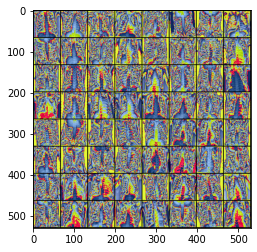

PNEUMONIA PNEUMONIA NORMAL PNEUMONIA NORMAL NORMAL NORMAL PNEUMONIA NORMAL NORMAL NORMAL PNEUMONIA NORMAL NORMAL PNEUMONIA PNEUMONIA NORMAL PNEUMONIA PNEUMONIA NORMAL PNEUMONIA PNEUMONIA NORMAL PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA NORMAL PNEUMONIA NORMAL NORMAL NORMAL NORMAL PNEUMONIA PNEUMONIA PNEUMONIA NORMAL PNEUMONIA NORMAL NORMAL NORMAL PNEUMONIA PNEUMONIA PNEUMONIA NORMAL NORMAL PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA NORMAL PNEUMONIA NORMAL PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA NORMAL NORMAL PNEUMONIA


In [6]:
#What do we input to dataset. Just check.
classes = ('NORMAL', 'PNEUMONIA')

def show_images(img):
    plt.imshow(transforms.functional.to_pil_image(img))
    plt.show()


images, labels = next(iter(train_loader))
show_images(utils.make_grid(images))  # should look weird due to normalization
print(*[classes[l] for l in labels])

#Should working about 1 minute before it shows images and labels

#Import GoogleNet

In [7]:
class GoogLeNet(nn.Module): 
    def __init__(self, in_channels = 3 , num_classes=2): 
        super(GoogLeNet, self).__init__()

        self.conv1 = conv_block(in_channels=in_channels, out_channels=64, kernel_size=(7,7), stride=(2,2), padding=(3,3))
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(kernel_size = 2, stride=1)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(1024, 2)

    def forward(self, x): 
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x


class Inception_block(nn.Module):
    def __init__(
        self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
    ):
        super(Inception_block, self).__init__()
        self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size=1),
            conv_block(red_3x3, out_3x3, kernel_size=3, padding=1),
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size=1),
            conv_block(red_5x5, out_5x5, kernel_size=5, padding=2),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            conv_block(in_channels, out_1x1pool, kernel_size=1),
        )

    def forward(self, x):
        return torch.cat(
            [self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1
        )


class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        return self.relu(self.batchnorm(self.conv(x)))

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GoogLeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

# Train and test functions for model results

In [9]:
def train(num_epochs):
  # Train Network
  train_avg_loss = []
  accuracy_model_train = []
  accuracy_model_test = []
  for num_epochs in range(num_epochs):
      train_losses = []
      for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
          # Get data to cuda if possible
          data = data.to(device=device)
          targets = targets.to(device=device)

          # forward
          scores = model(data)
          loss = criterion(scores, targets)

          # backward
          optimizer.zero_grad()
          loss.backward()
          train_losses.append(loss)
          # gradient descent or adam step
          optimizer.step()

      train_losses = torch.as_tensor(train_losses) #UPDATE5.1 (avoid copy), it is important  for .append
      mean_train_loss = torch.mean(train_losses) #UPDATE5.2 TO CONTROL PRINT
      train_avg_loss.append(mean_train_loss) # your code UPDATE5
      accuracy_train = check_accuracy(train_loader, model)
      accuracy_test = check_accuracy(test_loader, model)
      accuracy_model_train.append(accuracy_train)
      accuracy_model_test.append(accuracy_test)
      print(f'This is {num_epochs}')
      print(f'Train loss: {mean_train_loss}| Accuracy train: {accuracy_train} | Accuracy test: {accuracy_test}')
      
  return train_avg_loss, accuracy_model_train, accuracy_model_test


# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    return np.array(num_correct/num_samples)

def model_metrics(loader, model):
    model.eval()
    precision_temp = 0
    recall_temp = 0
    f1 = 0
    number_iter = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            precision_temp += sklearn.metrics.precision_score(y, predictions)
            recall_temp += sklearn.metrics.recall_score(y, predictions)
            f1 += sklearn.metrics.f1_score(y, predictions)
            number_iter += 1
    return precision_temp/number_iter, recall_temp/number_iter, f1/number_iter



#Run model

In [10]:
epoch = 30
model_train = train(epoch)

100%|██████████| 98/98 [11:19<00:00,  6.93s/it]


This is 0
Train loss: 0.3761991858482361| Accuracy train: 0.9277262687683105 | Accuracy test: 0.9261331558227539


100%|██████████| 98/98 [03:12<00:00,  1.97s/it]


This is 1
Train loss: 0.1600475311279297| Accuracy train: 0.9150943160057068 | Accuracy test: 0.9037492871284485


 84%|████████▎ | 82/98 [02:48<00:32,  2.05s/it]


KeyboardInterrupt: ignored

# Plot the results

In [ ]:
if model_train[1][0] > 0.75:
  metrics_training = model_metrics(train_loader, model)
  print(f"Accuracy on training set: {model_train[1][0]}, Precision: {metrics_training[0]}, Recall: {metrics_training[1]}, F1: {metrics_training[2]}")
  model_results_test, metrics_test = check_accuracy(test_loader, model), model_metrics(test_loader, model)
  print(f"Accuracy on test set: {model_results_test}, Precision: {metrics_test[0]}, Recall: {metrics_test[1]}, F1: {metrics_test[2]}")
  model_results_valid, metrics_valid = check_accuracy(valid_loader, model), model_metrics(valid_loader, model)
  print(f"Accuracy on valid set: {model_results_valid}, Precision: {metrics_valid[0]}, Recall: {metrics_valid[1]}, F1: {metrics_valid[2]}")
  
  path = '/content/drive/MyDrive/DATASET_FINAL/' + 'GoogLeNet_scratch'

  print("Model's state_dict:")
  for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
  torch.save(model.state_dict(), path)
  print('Model has been saved')
  
else:
  print('Training FAILED')
  print(f'Accuracy: {model_train}')